## 말라리아 셀 이미지
* 말라리아 스크리너 연구 활동의 분할된 세포의 얇은 혈액 도말 슬라이드 이미지
* 리소스가 제한된 지역에서 현미경 전문가의 부담을 줄이고 진단 정확도를 개선하기 위해 NLM(National Library of Medicine)의 일부인 Lister Hill National Center for Biomedical Communications(LHNCBC)의 연구원들은 모바일 애플리케이션을 개발
* 방글라데시 치타공 의과대학 병원에서 150명의 P. falciparum 감염자와 50명의 건강한 환자의 Giemsa 염색 얇은 혈액 도말 슬라이드를 수집하고 사진을 촬영
* 적혈구를 감지하고 분할하기 위해 레벨 세트 기반 알고리즘을 적용

### 이미지 출처 
* [LHNCBC Full Download List](https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets)
* [Malaria Cell Images Dataset | Kaggle](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria)
* 관련 논문 : [Performance evaluation of deep neural ensembles toward malaria parasite detection in thin-blood smear images [PeerJ]](https://peerj.com/articles/6977/)
* 해당 논문의 github : [sivaramakrishnan-rajaraman/Deep-Neural-Ensembles-toward-Malaria-Parasite-Detection-in-Thin-Blood-Smear-Images: This study evaluates the performance of custom and pretrained CNNs and construct an optimal model ensemble toward the challenge of classifying parasitized and normal cells in thin blood smear images. The results obtained are encouraging and superior to the state-of-the-art.](https://github.com/sivaramakrishnan-rajaraman/Deep-Neural-Ensembles-toward-Malaria-Parasite-Detection-in-Thin-Blood-Smear-Images)

<img src="https://i.imgur.com/okCbMzc.png" width="400">

## 라이브러리 로드

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

## 이미지 폴더 보기

In [37]:
# 이미지 다운로드
# !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

In [39]:
# images 폴더에 다운로드 받은 파일 압축 해제하기
# !unzip cell_images.zip

In [40]:
import os
for root, dirs, files in os.walk("./cell_images/"):
    print(root, dirs, len(files))

./cell_images/ ['Parasitized', 'Uninfected', 'cell_images'] 1
./cell_images/Parasitized [] 13780
./cell_images/Uninfected [] 13780
./cell_images/cell_images ['Parasitized', 'Uninfected'] 0
./cell_images/cell_images/Parasitized [] 13780
./cell_images/cell_images/Uninfected [] 13780


## 일부 이미지 미리보기

(136, 145, 3)
(151, 139, 3)


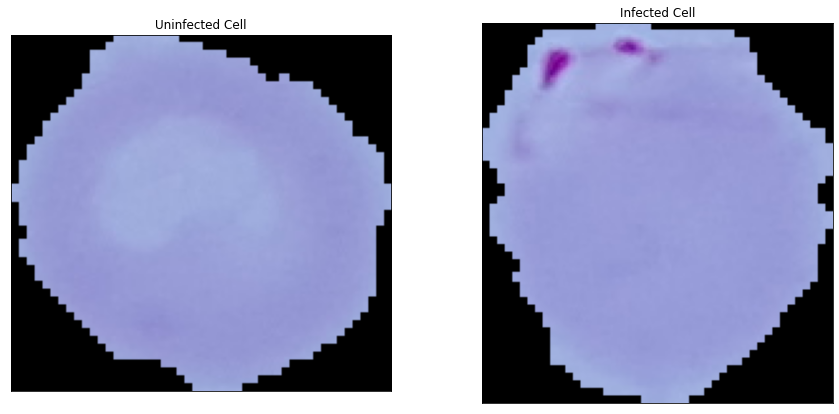

In [41]:
import cv2

upic = 'cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_131.png'
apic = 'cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png'
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
print(cv2.imread(upic).shape)
plt.imshow(cv2.imread(upic))
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cv2.imread(apic))
print(cv2.imread(apic).shape)
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

## 이미지 사이즈 설정
* 이미지의 사이즈가 불규칙하면 학습을 할 수 없기 때문에 리사이즈할 크기를 지정합니다.

In [42]:
width = 128
height = 128

## 데이터셋 나누기
* 학습, 검증 세트를 나눕니다.

In [43]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

### 학습 세트

In [44]:
trainDatagen = datagen.flow_from_directory(directory = 'cell_images/',
                                           target_size = (height, width),
                                           class_mode = 'binary',
                                           batch_size = 64,
                                           subset='training')

Found 44095 images belonging to 3 classes.


In [50]:
trainDatagen.num_classes

3

In [47]:
trainDatagen.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

### 검증 세트

In [45]:
valDatagen = datagen.flow_from_directory(directory = 'cell_images/',
                                         target_size =(height, width),
                                         class_mode = 'binary',
                                         batch_size = 64,
                                         subset='validation')

Found 11021 images belonging to 3 classes.


## 레이어 설정

<img src="https://d2l.ai/_images/lenet.svg">
* 이미지 출처 : https://d2l.ai/chapter_convolutional-neural-networks/lenet.html

* [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)와 [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) 층을 쌓는 일반적인 패턴으로 합성곱 층을 정의합니다.
 
* CNN은 배치(batch) 크기를 제외하고 (이미지 높이, 이미지 너비, 컬러 채널) 크기의 텐서(tensor)를 입력으로 받습니다. 
* 컬러 이미지는 (R,G,B) 세 개의 채널을 가집니다. (흑백 이미지는 채널이 하나 입니다.)


* filters : 컨볼루션 필터의 수 >> 필터 수 = 특징맵 수
* kernel_size : 컨볼루션 커널의 (행, 열)  >> 필터 사이즈
* padding : 경계 처리 방법
    * ‘valid’ : 유효한 영역만 출력이 됩니다. 따라서 출력 이미지 사이즈는 입력 사이즈보다 작습니다.
    * ‘same’ : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일합니다.
* input_shape : 모델에서 첫 레이어에서 정의 (height, width, channels)
*  activation : 활성화 함수 설정
    * ‘linear’ : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력
    * ‘relu’ : rectifier 함수, 은닉층에 주로 사용
    * ‘sigmoid’ : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 사용
    * ‘softmax’ : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 사용

* 합성곱 신경망 : https://www.tensorflow.org/tutorials/images/cnn

In [32]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(height, width, 3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

## 모델 요약

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)       

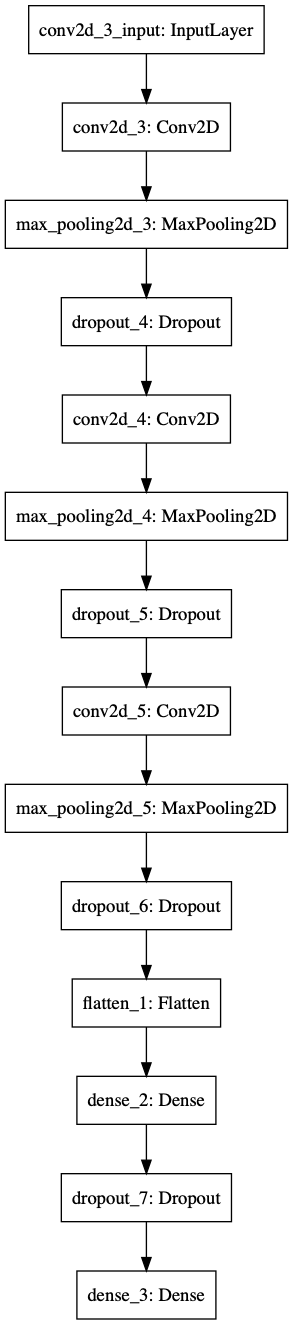

In [34]:
from tensorflow.keras.utils import plot_model

plot_model(model)

## 컴파일

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## 학습

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
history = model.fit(trainDatagen,
                    steps_per_epoch = len(trainDatagen),
                    epochs = 20,
                    validation_data = valDatagen,
                    validation_steps=len(valDatagen),
                    callbacks=[early_stop])

In [ ]:
df_hist = pd.DataFrame(history.history)
df_hist.head()

In [ ]:
df_hist[["accuracy", "val_accuracy"]].plot()